In [1]:
# Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler


import xgboost as xgb
##from sklearn.datasets import load_boston

In [2]:
# Carregando os dados
data = pd.read_csv('base_Dados_datatran2022 - Copia (2).csv',encoding='iso-8859-1',sep=';')

In [3]:
df = data

df.dropna(axis=0, subset=['br'],inplace=True)

In [33]:
count_class_0, count_class_1 = df.mortos.value_counts()

In [42]:
# Divide by class
df_class_0 = df[df['mortos'] == 0]
df_class_1 = df[df['mortos'] == 1]
df_class_0 = df_class_0.sample(count_class_0)
df_class_1 = df_class_1.sample(count_class_1)


In [73]:
from numpy.ma import count


df_class_1.mortos.count()



3718

In [63]:
from math import sqrt

from numpy.ma import count


scale_pos_weight = sqrt(df_class_0.mortos.count()/df_class_1.mortos.count())
scale_pos_weight

3.686657973629224

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54251 entries, 0 to 54250
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      54251 non-null  int64 
 1   data_inversa            54251 non-null  object
 2   dia_semana              54251 non-null  object
 3   horario                 54251 non-null  object
 4   uf                      54251 non-null  object
 5   br                      54251 non-null  int64 
 6   km                      54251 non-null  object
 7   municipio               54251 non-null  object
 8   causa_acidente          54251 non-null  object
 9   tipo_acidente           54251 non-null  object
 10  classificacao_acidente  54251 non-null  object
 11  fase_dia                54251 non-null  int64 
 12  sentido_via             54251 non-null  int64 
 13  condicao_metereologica  54251 non-null  int64 
 14  tipo_pista              54251 non-null  int64 
 15  tr

In [5]:
df = data

df = df.filter(["fase_dia","sentido_via","condicao_metereologica","tipo_pista","tracado_via","mortos",'feridos','veiculos'])

df["fase_dia"] = df['fase_dia'].astype('object')
df["sentido_via"] = df['sentido_via'].astype('object')
df["condicao_metereologica"] = df['condicao_metereologica'].astype('object')
df["tipo_pista"] = df['tipo_pista'].astype('object')
df["tracado_via"] = df['tracado_via'].astype('object')

df = pd.get_dummies(df,columns=['fase_dia',"sentido_via",'condicao_metereologica','tipo_pista','tracado_via'],drop_first=False)

In [46]:
# Separando os dados de entrada (X) e saída (y)
X = df.drop('mortos', axis=1)
y = df['mortos']

mortos
0    3718
1    3718
Name: count, dtype: int64


C:\Users\diegosilva\AppData\Roaming\Python\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


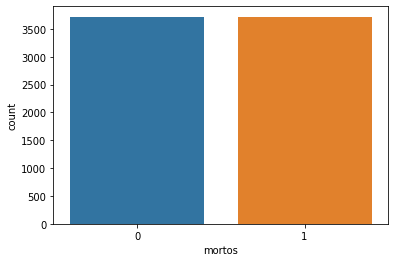

In [7]:
# usar técnica under-sampling
rus = RandomUnderSampler()
X_res, y_res = rus.fit_resample(X, y)
# ver o balanceamento das classes
print(pd.Series(y_res).value_counts())
# plotar a nova distribuição de classes
sns.countplot(y_res);

In [64]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [65]:
# Create an XGBoost classifier
model = xgb.XGBClassifier(random_state = 42, n_jobs = 1, scale_pos_weight = scale_pos_weight, n_estimators = 372)

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8862742688621282


In [66]:
# imprimir relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_test, y_pred, digits=4))

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.9500    0.9267    0.9382     15162
           1     0.2519    0.3357    0.2878      1114

    accuracy                         0.8863     16276
   macro avg     0.6009    0.6312    0.6130     16276
weighted avg     0.9022    0.8863    0.8937     16276



In [67]:
y_prob = model.predict_proba(X_test)[:, 1]

In [68]:
# Cálculo dos valores de TPR e FPR para diferentes valores de limiar de classificação
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

In [69]:
# Cálculo da AUC da curva ROC
roc_auc = roc_auc_score(y_test, y_prob)

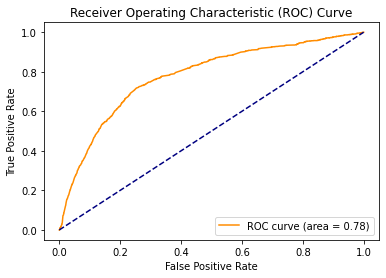

In [70]:
# Plotagem da curva ROC
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [71]:
# Cálculo da matriz de confusão
cm = confusion_matrix(y_test, y_pred)

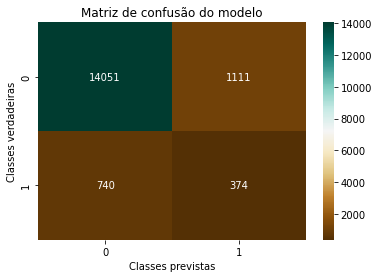

In [72]:
# Plotagem da matriz de confusão usando a biblioteca seaborn
sns.heatmap(cm, annot=True, cmap='BrBG', fmt=".0f")
plt.title('Matriz de confusão do modelo')
plt.xlabel('Classes previstas')
plt.ylabel('Classes verdadeiras')
plt.show()

In [ ]:
#RESULTADOS COM RANDOM FOREST

In [17]:
# Criação e treinamento do modelo de Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, random_state=42)

In [18]:
# Realização das previsões no conjunto de teste
y_pred = rfc.predict(X_test)

In [19]:
# imprimir relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_test, y_pred, digits=4))

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.7500    0.7507    0.7503      1103
           1     0.7560    0.7553    0.7557      1128

    accuracy                         0.7530      2231
   macro avg     0.7530    0.7530    0.7530      2231
weighted avg     0.7530    0.7530    0.7530      2231



In [20]:
# Avaliação do modelo
accuracy = rfc.score(X_test, y_test)
print('Acurácia do modelo: {:.2f}%'.format(accuracy*100))

Acurácia do modelo: 75.30%


In [21]:
# Cálculo do recall
recall = recall_score(y_test, y_pred,average='weighted')
print('Recall do modelo: {:.2f}%'.format(recall*100))

Recall do modelo: 75.30%


In [22]:
# Cálculo da precisão
precision = precision_score(y_test, y_pred, average='weighted')
print('Precisão do modelo: {:.2f}%'.format(precision*100))

Precisão do modelo: 75.30%


In [23]:
# Cálculo do F1-score
f1 = f1_score(y_test, y_pred, average='weighted')
print('F1-score do modelo: {:.2f}%'.format(f1*100))

F1-score do modelo: 75.30%


In [24]:
y_prob = rfc.predict_proba(X_test)[:, 1]

In [25]:
# Cálculo dos valores de TPR e FPR para diferentes valores de limiar de classificação
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

In [26]:
# Cálculo da AUC da curva ROC
roc_auc = roc_auc_score(y_test, y_prob)

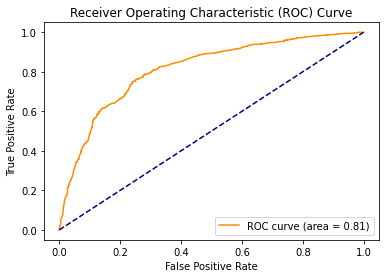

In [27]:
# Plotagem da curva ROC
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [28]:
# Cálculo da matriz de confusão
cm = confusion_matrix(y_test, y_pred)

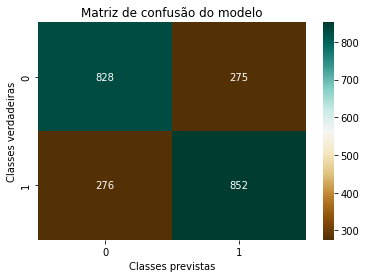

In [29]:
# Plotagem da matriz de confusão usando a biblioteca seaborn
sns.heatmap(cm, annot=True, cmap='BrBG', fmt=".0f")
plt.title('Matriz de confusão do modelo')
plt.xlabel('Classes previstas')
plt.ylabel('Classes verdadeiras')
plt.show()